In [1]:
import time
import math
import numpy as np
import pylab as py
from matplotlib import pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
from tqdm.auto import tqdm

/Users/troy/.pyenv/versions/3.10.6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Me = 6e24  # Mass of Earth in kg
Ms = 2e30  # Mass of Sun in kg
Mj = 1.9e27  # Mass of Jupiter

G = 6.673e-11  # Gravitational Constant

RR = 1.496e11  # Normalizing distance in km (= 1 AU)
MM = 6e24  # Normalizing mass
TT = 365 * 24 * 60 * 60.0  # Normalizing time (1 year)

FF = (G * MM**2) / RR**2  # Unit force
EE = FF * RR  # Unit energy

GG = (MM * G * TT**2) / (RR**3)

Me = Me / MM  # Normalized mass of Earth
Ms = Ms / MM  # Normalized mass of Sun
Mj = 500 * Mj / MM  # Normalized mass of Jupiter/Super Jupiter

In [3]:
def force_es(r):
    F= np.zeros(2)
    Fmag = GG * Me * Ms / (np.linalg.norm(r) + 1e-20) ** 2
    theta = math.atan(np.abs(r[1]) / (np.abs(r[0]) + 1e-20))
    F[0] = Fmag * np.cos(theta)
    F[1] = Fmag * np.sin(theta)
    if r[0] > 0:
        F[0] = -F[0]
    if r[1] > 0:
        F[1] = -F[1]

    return F


def force_js(r):
    F = np.zeros(2)
    Fmag = GG * Mj * Ms / (np.linalg.norm(r) + 1e-20) ** 2
    theta = math.atan(np.abs(r[1]) / (np.abs(r[0]) + 1e-20))
    F[0] = Fmag * np.cos(theta)
    F[1] = Fmag * np.sin(theta)
    if r[0] > 0:
        F[0] = -F[0]
    if r[1] > 0:
        F[1] = -F[1]

    return F


def force_ej(re, rj):
    r = np.zeros(2)
    F = np.zeros(2)
    r[0] = re[0] - rj[0]
    r[1] = re[1] - rj[1]
    Fmag = GG * Me * Mj / (np.linalg.norm(r) + 1e-20) ** 2
    theta = math.atan(np.abs(r[1]) / (np.abs(r[0]) + 1e-20))
    F[0] = Fmag * np.cos(theta)
    F[1] = Fmag * np.sin(theta)
    if r[0] > 0:
        F[0] = -F[0]
    if r[1] > 0:
        F[1] = -F[1]

    return F


def force(r, planet, ro):
    if planet == "earth":
        return force_es(r) + force_ej(r, ro)
    if planet == "jupiter":
        return force_js(r) - force_ej(r, ro)


def dr_dt(t, v, planet, r0):
    return np.array(v)


def dv_dt(t, r, planet, r0):

    F = force(r, planet, r0)
    if planet == "earth":
        y = F / Me
    if planet == "jupiter":
        y = F / Mj
    return y


#################################


def KineticEnergy(v):
    vn = np.linalg.norm(v)
    return 0.5 * Me * vn**2


def PotentialEnergy(r):
    fmag = np.linalg.norm(force_es(r))
    rmag = np.linalg.norm(r)
    return -fmag * rmag


def AngMomentum(r, v):
    rn = np.linalg.norm(r)
    vn = np.linalg.norm(v)
    r = r / rn
    v = v / vn
    rdotv = r[0] * v[0] + r[1] * v[1]
    theta = math.acos(rdotv)
    return Me * rn * vn * np.sin(theta)


def AreaCalc(r1, r2):
    r1n = np.linalg.norm(r1)
    r2n = np.linalg.norm(r2)
    r1 = r1 + 1e-20
    r2 = r2 + 1e-20
    theta1 = math.atan(abs(r1[1] / r1[0]))
    theta2 = math.atan(abs(r2[1] / r2[0]))
    rn = 0.5 * (r1n + r2n)
    del_theta = np.abs(theta1 - theta2)
    return 0.5 * del_theta * rn**2

In [27]:
def rk4_method(t0,v0_earth, v0_jupiter, r0_earth, r0_jupiter, h, n):
    """
    Use the fourth-order Runge-Kutta method (RK4) to solve the numerical solution of ordinary differential equations.

    Parameters:

    dv_dt: Function dv_dt(r, t), representing the differential equation dv/dt = dv_dt(r, t)

    dr_dt: Function dr_dt(v, t), representing the differential equation dr/dt = dr_dt(v, t)

    v0: Initial v value

    r0: Initial r value

    h: Step size

    n: Number of iterations

    Return value: A list containing x and corresponding y values.
    """
    
    t_values = [t0]
    v_values_earth = [v0_earth]
    v_values_jupiter = [v0_jupiter]
    r_values_earth = [r0_earth]
    r_values_jupiter = [r0_jupiter]
    
    for i in tqdm(range(n)):
        # print(i)
        t = t_values[-1]
        
        v_earth = v_values_earth[-1]
        v_jupiter = v_values_jupiter[-1]
        r_earth = r_values_earth[-1]
        r_jupiter = r_values_jupiter[-1]
        
        # Speed    

        l1_earth = h * dv_dt(t, r_earth, 'earth', r_jupiter)
        l2_earth = h * dv_dt(t + h/2, r_earth + h*l1_earth/2, 'earth', r_jupiter)
        l3_earth = h * dv_dt(t + h/2, r_earth + h*l2_earth/2, 'earth', r_jupiter)
        l4_earth = h * dv_dt(t + h, r_earth + h*l3_earth, 'earth', r_jupiter)

        l1_jupiter = h * dv_dt(t, r_jupiter, 'jupiter', r_earth)
        l2_jupiter = h * dv_dt(t + h/2, r_jupiter + h*l1_jupiter/2, 'jupiter', r_earth)
        l3_jupiter = h * dv_dt(t + h/2, r_jupiter + h*l2_jupiter/2, 'jupiter', r_earth)
        l4_jupiter = h * dv_dt(t + h, r_jupiter + h*l3_jupiter, 'jupiter', r_earth)
        
        v_next_earth = v_earth + (l1_earth + 2*l2_earth + 2*l3_earth + l4_earth) / 6
        v_next_jupiter = v_jupiter + (l1_jupiter + 2*l2_jupiter + 2*l3_jupiter + l4_jupiter) / 6

        # Position

        k1_earth = h * dr_dt(t, v_earth, 'earth', r_jupiter)
        k2_earth = h * dr_dt(t + h/2, v_earth + h*k1_earth/2, 'earth', r_jupiter)
        k3_earth = h * dr_dt(t + h/2, v_earth + h*k2_earth/2, 'earth', r_jupiter)
        k4_earth = h * dr_dt(t + h, v_earth + h*k3_earth, 'earth', r_jupiter)

        k1_jupiter = h * dr_dt(t, v_jupiter, 'jupiter', r_jupiter)
        k2_jupiter = h * dr_dt(t + h/2, v_jupiter + h*k1_jupiter/2, 'jupiter', r_jupiter)
        k3_jupiter = h * dr_dt(t + h/2, v_jupiter + h*k2_jupiter/2, 'jupiter', r_jupiter)
        k4_jupiter = h * dr_dt(t + h, v_jupiter + h*k3_jupiter, 'jupiter', r_jupiter)
        
        r_next_earth = r_earth + (k1_earth + 2*k2_earth + 2*k3_earth + k4_earth) / 6
        r_next_jupiter = r_jupiter + (k1_jupiter + 2*k2_jupiter + 2*k3_jupiter + k4_jupiter) / 6

        
        t_next = t + h

        t_values.append(t_next)
        v_values_earth.append(v_next_earth)
        v_values_jupiter.append(v_next_jupiter)
        r_values_earth.append(r_next_earth)
        r_values_jupiter.append(r_next_jupiter)
    
    return np.array(t_values), [np.array(r_values_earth), np.array(r_values_jupiter)], [np.array(v_values_earth), np.array(v_values_jupiter)]

In [5]:
ri = [1496e8 / RR, 0]  # initial position of earth
vv = np.sqrt(Ms * GG / ri[0])  # Magnitude of Earth's initial velocity
vi = [
    0,
    vv * 1.0,
]  # Initial velocity vector for Earth.Taken to be along y direction as ri is on x axis.



rji = [5.2, 0]  # initial position of Jupiter
vvj = 13.06e3 * TT / RR  # Magnitude of Jupiter's initial velocity
vji = [0, vvj * 1.0]  # Initial velocity vector for Jupiter

In [6]:
rlt = rk4_method(v0_earth=vi, v0_jupiter=vji, r0_earth=ri, r0_jupiter=rji, t0=0, h=5e-6, n=40000000)

100%|██████████| 40000000/40000000 [1:24:59<00:00, 7843.85it/s]


In [7]:
t, r, v = rlt

/Users/troy/.pyenv/versions/3.10.6/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/troy/.pyenv/versions/3.10.6/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


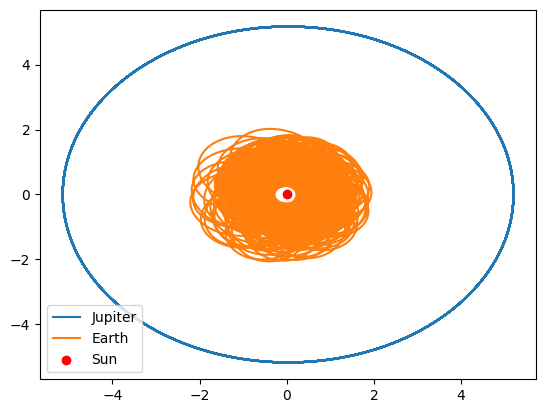

In [8]:
plt.plot(r[1][:,0], r[1][:,1], label="Jupiter")
plt.plot(r[0][:,0], r[0][:,1], label="Earth")
plt.scatter(0,0, label="Sun",c='r')
plt.legend()

In [9]:
rj = r[1][::1000]
vj = v[1][::1000]
re = r[0][::1000]
ve = v[0][::1000]
tt = t[::1000]

In [10]:
KE = np.array(np.vectorize(KineticEnergy,signature="(n)->()")(ve))
PE = np.array(np.vectorize(PotentialEnergy,signature="(n)->()")(re))
# np.vectorize(AngMomentum,signature="(n)->()")(r[1], v[1])

Text(0, 0.5, 'Energy (Joules)')

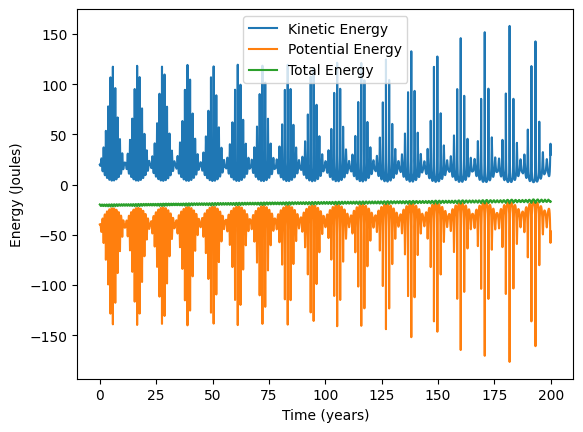

In [11]:
plt.plot(tt, KE, label="Kinetic Energy")
plt.plot(tt, PE, label="Potential Energy")
plt.plot(tt, KE + PE, label="Total Energy")
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Energy (Joules)")

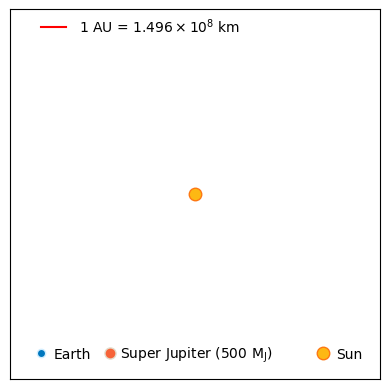

In [12]:
# Function for setting up the animation

fig, ax = plt.subplots()
ax.axis("square")
ax.set_xlim((-7.2, 7.2))
ax.set_ylim((-7.2, 7.2))
ax.get_xaxis().set_ticks([])  # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])  # enable this to hide y axis ticks

ax.plot(0, 0, "o", markersize=9, markerfacecolor="#FDB813", markeredgecolor="#FD7813")
(line1,) = ax.plot(
    [], [], "o-", color="#d2eeff", markevery=10000, markerfacecolor="#0077BE", lw=2
)  # line for Earth
(line2,) = ax.plot(
    [],
    [],
    "o-",
    color="#e3dccb",
    markersize=8,
    markerfacecolor="#f66338",
    lw=2,
    markevery=10000,
)  # line for Jupiter


ax.plot([-6, -5], [6.5, 6.5], "r-")
ax.text(-4.5, 6.3, r"1 AU = $1.496 \times 10^8$ km")

ax.plot(-6, -6.2, "o", color="#d2eeff", markerfacecolor="#0077BE")
ax.text(-5.5, -6.4, "Earth")

ax.plot(-3.3, -6.2, "o", color="#e3dccb", markersize=8, markerfacecolor="#f66338")
ax.text(-2.9, -6.4, r"Super Jupiter (500 $\mathrm{M_J}$)")

ax.plot(
    5, -6.2, "o", markersize=9, markerfacecolor="#FDB813", markeredgecolor="#FD7813"
)
ax.text(5.5, -6.4, "Sun")
ttl = ax.text(0.24, 1.05, "", transform=ax.transAxes, va="center")
# plt.title('Elapsed time, T=%i years' %u)

In [13]:
# initialization animation function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    ttl.set_text("")

    return (line1, line2, ttl)

In [14]:
rj = r[1][::1000]
re = r[0][::1000]
tt = t[::1000]

In [15]:
# Animation function. Reads out the positon coordinates sequentially
def animate(i):
    earth_trail = 40
    jupiter_trail = 200
    tm_yr = "Elapsed time = " + str(round(tt[i], 1)) + " years"
    ttl.set_text(tm_yr)
    line1.set_data(
        re[i : max(1, i - earth_trail) : -1, 0], re[i : max(1, i - earth_trail) : -1, 1]
    )
    line2.set_data(
        rj[i : max(1, i - jupiter_trail) : -1, 0],
        rj[i : max(1, i - jupiter_trail) : -1, 1],
    )

    return (line1, line2)

In [16]:
# Call animation function

anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=4000, interval=10, blit=True
)

In [17]:
HTML(anim.to_html5_video())

In [21]:
import pandas as pd
data = {
        't':tt,
        're_x':re[:,0],
        're_y':re[:,1],
        've_x':ve[:,0],
        've_y':ve[:,1],
        'rj_x':rj[:,0],
        'rj_y':rj[:,1],
        'vj_x':vj[:,0],
        'vj_y':vj[:,1],
       }

df = pd.DataFrame({k:pd.Series(v) for k,v in data.items()})
df.to_csv("./result/4e6.csv", index=False)

In [22]:
df = pd.read_csv("./result/4e6.csv")

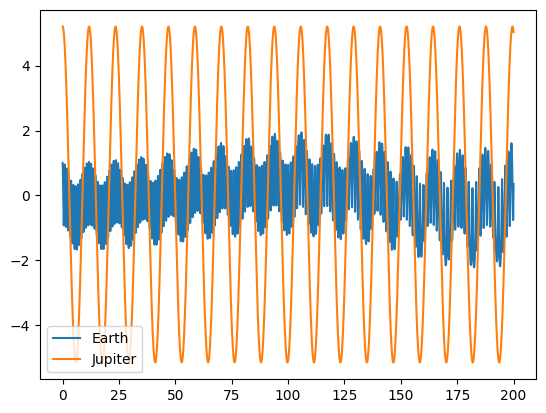

In [26]:
plt.plot(df['t'], df['re_x'], label="Earth")
plt.plot(df['t'], df['rj_x'], label="Jupiter")
plt.legend()

In [57]:
def AngMomentum(r, v):
    rn = np.linalg.norm(r)
    vn = np.linalg.norm(v)
    r = r / rn
    v = v / vn
    rdotv = r[0] * v[0] + r[1] * v[1]
    theta = math.acos(rdotv)
    return Me * rn * vn * np.sin(theta)

In [72]:
AM_earth = []
AM_jupiter = []

for i in range(len(tt)):
    r = re[i]
    v = ve[i]
    AM_earth.append(AngMomentum(r,v))
    r = rj[i]
    v = vj[i]
    AM_jupiter.append(AngMomentum(r,v))




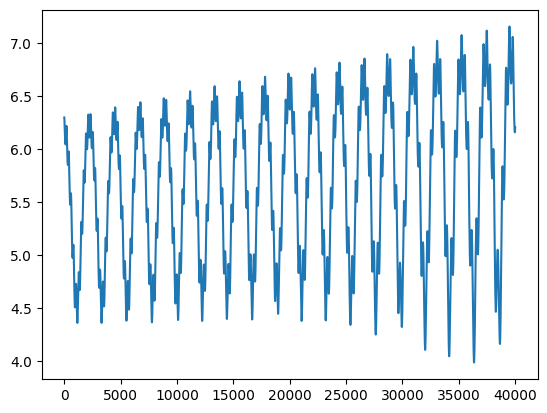

In [75]:
plt.plot(AM_earth, label="Earth")
# plt.plot(AM_jupiter, label="Jupiter")

In [39]:
AngMomentum([r[1][0], v[1][0]])

14.315994866310161

In [51]:
AngMomentum([re[0], ve[0]])

6.296290782522899